In [1]:
import sys
sys.path.insert(0,'..')

import os
import json
import pickle
import requests
import shutil
import random
import numpy as np

from collections import defaultdict
from scipy import ndimage
from datetime import date
from datetime import datetime
from PIL import Image
import matplotlib.pyplot as plt

#We are using owslib to download images from a WMS Service
#install with 'pip install owslib'

import owslib

from owslib.wms import WebMapService

#pyshp is necessary for loading and saving shapefiles
#install with 'pip install pyshp'
import shapefile

# Install opencv with 'pip install opencv-python'
import cv2

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
x_min = 90000
y_min = 427000
dx, dy = 200, 200
no_tiles_x = 100
no_tiles_y = 100
total_no_tiles = no_tiles_x * no_tiles_y

x_max = x_min + no_tiles_x * dx
y_max = y_min + no_tiles_y * dy
bounding_box = [x_min, y_min, x_max, y_max]

TILE_FOLDER = "./datasets/image_tiles_200/"
URL_TILES = "https://geodata.nationaalgeoregister.nl/luchtfoto/rgb/wms?request=GetCapabilities"

URL_SHP = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shp'
URL_PRF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.prj'
URL_DBF = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.dbf'
URL_SHX = 'https://www.rijkswaterstaat.nl/apps/geoservices/geodata/dmc/nwb-wegen/geogegevens/shapefile/Nederland_totaal/01-08-2017/Wegvakken/Wegvakken.shx'

URLS_SHAPEFILES = [URL_SHP, URL_PRF, URL_DBF, URL_SHX]

DATA_FOLDER = "./data/nwb_wegvakken/"

json_filename = DATA_FOLDER + '2017_09_wegvakken.json'

# 1. Downloading the image tiles

In [ ]:
#Skip if you already have the image tiles. Will take ~ 2hours.
wms = WebMapService(URL_TILES, version='1.1.1')

if not os.path.exists(TILE_FOLDER):
    os.makedirs(TILE_FOLDER)

for ii in range(0,100):
    print(ii)
    for jj in range(0,no_tiles_y):
        ll_x_ = x_min + ii*dx
        ll_y_ = y_min + jj*dy
        bbox = (ll_x_, ll_y_, ll_x_ + dx, ll_y_ + dy) 
        img = wms.getmap(layers=['Actueel_ortho25'], srs='EPSG:28992', bbox=bbox, size=(256, 256), format='image/jpeg', transparent=True)
        filename = "{}{}_{}_{}_{}.jpg".format(TILE_FOLDER, bbox[0], bbox[1], bbox[2], bbox[3])
        out = open(filename, 'wb')
        out.write(img.read())
        out.close()


## 1b. Downloading the shapefiles

In [ ]:
#Skip if you already have the shapefiles. Will take ~ 1hour.
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

for url in URLS_SHAPEFILES:
    filename = url.split('/')[-1]
    print("Downloading file {}".format(filename))
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(DATA_FOLDER + filename, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)     

# 2. Loading shapefile and converting to (GEO)Json

In [ ]:
# Skip if conversion already done and "json_filename" already saved
def json_serial(obj):
    """JSON serializer for objects not serializable by default json code"""

    if isinstance(obj, (datetime, date)):
        serial = obj.isoformat()
        return serial
    if isinstance(obj, bytes):
        return {'__class__': 'bytes',
                '__value__': list(obj)}
    raise TypeError ("Type %s not serializable" % type(obj))

reader = shapefile.Reader(DATA_FOLDER + 'Wegvakken.shp')
fields = reader.fields[1:]
field_names = [field[0] for field in fields]

buffer = []
for sr in reader.shapeRecords()[:500000]:
    atr = dict(zip(field_names, sr.record))
    geom = sr.shape.__geo_interface__
    buffer.append(dict(type="Feature", geometry=geom, properties=atr)) 


json_file = open(json_filename, "w")
json_file.write(json.dumps({"type": "FeatureCollection", "features": buffer}, indent=2, default=json_serial) + "\n")
json_file.close()

# 3. Declaring variables and methods

In [3]:
dict_roadtype = {
    "G": 'Gemeente',
    "R": 'Rijk',
    "P": 'Provincie',
    "W": 'Waterschap',
    'T': 'Andere wegbeheerder',
    '' : 'leeg'
}

dict_roadtype_to_color = {
    "G": 'red',
    "R": 'blue',
    "P": 'green',
    "W": 'magenta',
    'T': 'yellow',
    '' : 'leeg'
}

FEATURES_KEY = 'features'
PROPERTIES_KEY = 'properties'
GEOMETRY_KEY = 'geometry'
COORDINATES_KEY = 'coordinates'
WEGSOORT_KEY = 'WEGBEHSRT'

MINIMUM_NO_POINTS_PER_TILE = 4
POINTS_PER_METER = 10 # Changed by David from 0.1

INPUT_FOLDER_TILES = './datasets/image_tiles_200/'

In [4]:
def add_to_dict(d1, d2, coordinates, rtype):
    coordinate_ll_x = int((coordinates[0] // dx)*dx)
    coordinate_ll_y = int((coordinates[1] // dy)*dy)
    coordinate_ur_x = int((coordinates[0] // dx)*dx + dx)
    coordinate_ur_y = int((coordinates[1] // dy)*dy + dy)
    tile = "{}_{}_{}_{}.jpg".format(coordinate_ll_x, coordinate_ll_y, coordinate_ur_x, coordinate_ur_y)
    
    rel_coord_x = (coordinates[0] - coordinate_ll_x) / dx
    rel_coord_y = (coordinates[1] - coordinate_ll_y) / dy
    value = (rtype, rel_coord_x, rel_coord_y)
    d1[tile].append(value)
    d2[rtype].add(tile)

def coord_is_in_bb(coord, bb):
    x_min = bb[0]
    y_min = bb[1]
    x_max = bb[2]
    y_max = bb[3]
    return coord[0] > x_min and coord[0] < x_max and coord[1] > y_min and coord[1] < y_max

def retrieve_roadtype(elem):
    return elem[PROPERTIES_KEY][WEGSOORT_KEY]
   
def retrieve_coordinates(elem):
    return elem[GEOMETRY_KEY][COORDINATES_KEY]

def eucledian_distance(p1, p2):
    diff = np.array(p2)-np.array(p1)
    return np.linalg.norm(diff)

def calculate_intermediate_points(p1, p2, no_points):
    dx = (p2[0] - p1[0]) / (no_points + 1)
    dy = (p2[1] - p1[1]) / (no_points + 1)
    return [[p1[0] + i * dx, p1[1] +  i * dy] for i in range(1, no_points+1)]



# 4. Map contents of shapefile to the tiles

In [ ]:
filename_wegvakken = json_filename
dict_wegvakken = json.load(open(filename_wegvakken))[FEATURES_KEY]

In [ ]:
d_tile_contents = defaultdict(list)
d_roadtype_tiles = defaultdict(set)
    
for elem in dict_wegvakken:
    coordinates = retrieve_coordinates(elem)
    rtype = retrieve_roadtype(elem)
    coordinates_in_bb = [coord for coord in coordinates if coord_is_in_bb(coord, bounding_box)]
    if len(coordinates_in_bb)==1:
        coord = coordinates_in_bb[0]
        add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
    if len(coordinates_in_bb)>1:
        add_to_dict(d_tile_contents, d_roadtype_tiles, coordinates_in_bb[0], rtype)
        for ii in range(1,len(coordinates_in_bb)):
            previous_coord = coordinates_in_bb[ii-1]
            coord = coordinates_in_bb[ii]
            add_to_dict(d_tile_contents, d_roadtype_tiles, coord, rtype)
            
            dist = eucledian_distance(previous_coord, coord)
            no_intermediate_points = int(dist*POINTS_PER_METER)           
            intermediate_coordinates = calculate_intermediate_points(previous_coord, coord, no_intermediate_points)
            for intermediate_coord in intermediate_coordinates:
                add_to_dict(d_tile_contents, d_roadtype_tiles, intermediate_coord, rtype)


# 4a. Create dictionary of road-pixel matrices

In [ ]:
# Initialize dictionary
d_road_pixels = {}

# Loop through all image tiles
for ii in range(0,no_tiles_x):
    for jj in range(0,no_tiles_y):
        ll_x = x_min + ii*dx
        ll_y = y_min + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile   
        # Extract list of road coordinates in tile
        tile_contents = d_tile_contents[tile]

        # Find pixel elements corresponding to roads
        # Fill in matrix of values
        pixel_mat = np.zeros((256,256))
        for elem in tile_contents:
            x = int(elem[1]*255)
            y = int((1-elem[2])*255)
            pixel_mat[y,x] = 1
        d_road_pixels[tile] = pixel_mat
        
        #plt.spy(pixel_mat)
        #plt.show()

# 4b. Visualize results

In [ ]:
x0 = 95000
y0 = 430000

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile        
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = plt.imread(filename).astype(int)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
x0 = 95400
y0 = 432000
POINTS_PER_METER = 0

fig, axarr = plt.subplots(nrows=11,ncols=11, figsize=(16,16))

for ii in range(0,11):
    for jj in range(0,11):
        ll_x = x0 + ii*dx
        ll_y = y0 + jj*dy
        ur_x = ll_x + dx
        ur_y = ll_y + dy
        tile = "{}_{}_{}_{}.jpg".format(ll_x, ll_y, ur_x, ur_y)
        filename = INPUT_FOLDER_TILES + tile
        tile_contents = d_tile_contents[tile]
        
        ax = axarr[10-jj, ii]
        image = plt.imread(filename).astype(int)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(rgb_image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        for elem in tile_contents:
            color = dict_roadtype_to_color[elem[0]]
            x = elem[1]*256
            y = (1-elem[2])*256
            ax.scatter(x,y,c=color,s=10)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# 4c. Statistics about the dataset

In [ ]:
for rtype in d_roadtype_tiles.keys():
    roadtype = dict_roadtype[rtype]
    no_tiles = len(d_roadtype_tiles[rtype])
    print("Of roadtype {} ({}) there are {} tiles.".format(rtype, roadtype, no_tiles))

# 5. Prepare dataset for CNN

In [ ]:
def randomize(dataset, labels1, labels2):
    permutation = np.random.permutation(dataset.shape[0])
    print(permutation.shape)
    print(dataset.shape)
    print(labels1.shape)
    print(labels2.shape)
    randomized_dataset = dataset[permutation, :, :, :]
    randomized_labels1 = labels1[permutation, :]
    randomized_labels2 = labels2[permutation]
    return randomized_dataset, randomized_labels1, randomized_labels2

#  5a. Split each image into 16 tiles

In [ ]:
def split_data(image, image_data, image_width, image_height, image_depth, split_factor):
    
    new_image_height = int(image_height/split_factor)
    new_image_width = int(image_width/split_factor)
    stride_x = new_image_width
    stride_y = new_image_height
    
    tiles_x = split_factor
    tiles_y = split_factor
    n_new_images = tiles_x*tiles_y

    # Initialize arrays for cropped images
    split_images = np.ndarray(shape=(n_new_images, new_image_width, \
                            new_image_height, image_depth), dtype=int)
    split_labels = np.ndarray(shape=(n_new_images, new_image_width, \
                            new_image_height), dtype=int)
    labels_roadpixel_img = d_road_pixels[image].astype(int)
    
    # Loop through matrices
    count = 0
    for i in range(tiles_x):
        for j in range(tiles_y):
            split_images[count] = image_data[(i*stride_x):((i+1)*stride_x), (j*stride_y):((j+1)*stride_y), :]
            split_labels[count] = labels_roadpixel_img[(i*stride_x):((i+1)*stride_x), (j*stride_y):((j+1)*stride_y)]
            count += 1

    # Check to make sure totals line up
    assert sum(split_images.flatten()) == sum(split_images.flatten())
    assert sum(labels_roadpixel_img.flatten()) == sum(split_labels.flatten())
    return split_images, split_labels
        
    

In [ ]:
image_width = 256
image_height = 256
image_depth = 3
total_no_images = 10000
split_factor = 4

new_image_height = int(image_height/split_factor)
new_image_width = int(image_width/split_factor)
new_images = split_factor**2
new_total_images = new_images*total_no_images

image_files = os.listdir(INPUT_FOLDER_TILES)

# Initialize new datasets for cropped images
labels_filename = []
dataset = np.ndarray(shape=(new_total_images, new_image_width, \
                            new_image_height, image_depth), dtype=int)
labels_roadpixel = np.zeros((new_total_images, new_image_width * new_image_height))

# Loop through each image and add to dataset
for counter, image in enumerate(image_files):
    filename = INPUT_FOLDER_TILES + image
    image_data = plt.imread(filename).astype(int)
    split_images, split_labels_roadpixel = split_data(image, image_data, image_width, image_height, image_depth, split_factor)
    for i in range(new_images):
        labels_filename.append(image+"_"+str(i))           
        labels_roadpixel[counter*new_images + i] = split_labels_roadpixel[i].flatten()
        dataset[counter*new_images + i, :, :] = split_images[i]
    if counter % 1000 == 0:
        print("{} images have been loaded.".format(counter))
        
print(dataset.shape)
print(labels_roadpixel.shape)

In [ ]:
labels_filename = np.array(labels_filename)
print("Randomizing dataset...")
dataset, labels_roadpixels, labels_filename = randomize(dataset, labels_roadpixel, labels_filename)

In [ ]:
# Split into train/validation/test sets
# For training set, subset on images with roads only
start_train_dataset = 0
start_valid_dataset = 150000
start_test_dataset = 155000
total_no_images = 160000

sum_labels = np.sum(labels_roadpixels[0:start_valid_dataset,:], axis=1)
idx_train = np.where(sum_labels > 0)[0]

output_pickle_file = './data/sattelite_dataset_pixel.pickle'

f = open(output_pickle_file, 'wb')
save = {
'train_dataset': dataset[idx_train,:,:,:],
'train_labels_roadpixels': labels_roadpixels[idx_train,:],
'train_labels_filename': labels_filename[idx_train],
'valid_dataset': dataset[start_valid_dataset:start_test_dataset,:,:,:],
'valid_labels_roadpixels': labels_roadpixels[start_valid_dataset:start_test_dataset,:],
'valid_labels_filename': labels_filename[start_valid_dataset:start_test_dataset],
'test_dataset': dataset[start_test_dataset:total_no_images,:,:,:],
'test_labels_roadpixels': labels_roadpixels[start_test_dataset:total_no_images,:],
'test_labels_filename': labels_filename[start_test_dataset:total_no_images]
}
pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
f.close()

print("\nsaved dataset to {}".format(output_pickle_file))

# 6. The Convolutional neural network (Using ResNet-14 for pixel level classification)

In [23]:
import tensorflow as tf
from cnn_models.resnet14pixel import * 
from keras import optimizers
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

In [20]:
# Define custom binary loss function with weights
def customLoss(pos_weight = .5):
    
    def weighted_binary_crossentropy(y_true, y_pred, weight = pos_weight) :
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        logloss = -(y_true * K.log(y_pred) * weight + (1 - y_true) * K.log(1 - y_pred) * (1 - weight))   
        return K.mean(logloss, axis=-1)

    return weighted_binary_crossentropy

In [6]:
# Define model
model = ResNet14(input_shape = (64, 64, 3))
model.compile(optimizer='adam',
              loss = customLoss(pos_weight = .83),
              #loss = 'binary_crossentropy',
              metrics=['accuracy'])

# LOAD RESIZED IMAGES DATASET

In [7]:
# Load dataset with resized images
pickle_file = './data/sattelite_dataset_pixel_resize.pickle'
f = open(pickle_file, 'rb')
save = pickle.load(f)

X_train_r = save['train_dataset']
Y_train = save['train_labels_roadpixels'].astype(dtype = int)
X_valid_r = save['valid_dataset']
Y_valid = save['valid_labels_roadpixels'].astype(dtype = int)
X_test_r = save['test_dataset']
Y_test = save['test_labels_roadpixels'].astype(dtype = int)

f.close()

In [8]:
# Normalize image vectors
X_train = X_train_r/255.
X_valid = X_valid_r/255.
X_test = X_test_r/255.

# Standardize images by pixel across training examples
X_train_mean = np.mean(X_train, axis = 0)
X_train_var = np.var(X_train, axis = 0)
X_train = (X_train - X_train_mean) / X_train_var
X_valid = (X_valid - X_train_mean) / X_train_var
X_test = (X_test - X_train_mean) / X_train_var

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 4562
number of test examples = 1000
X_train shape: (4562, 64, 64, 3)
Y_train shape: (4562, 4096)
X_test shape: (1000, 64, 64, 3)
Y_test shape: (1000, 4096)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


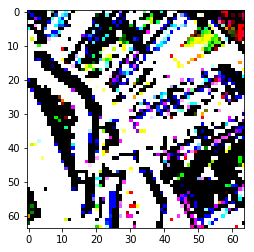

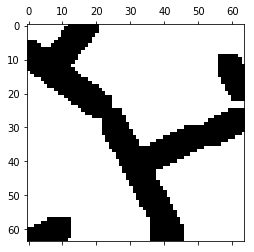

In [9]:
# Print sample image
for i in range(22,23):
    plt.imshow(X_train[i,:])
    plt.show()
    plt.spy(Y_train[i,:].reshape(64,64))
    plt.show()

In [21]:
# Load existing model (if applicable)
model_filepath = './data/resnet10_road_pixels200_180606.h5'
model = load_model(model_filepath,custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy})

In [10]:
# Print % of road/non-road pixels
tot_road_pixels = sum(Y_train[:,:].flatten())
tot_pixels = Y_train.shape[0] * Y_train.shape[1]
print("% non-road pixels:",1 - tot_road_pixels/tot_pixels)


% non-road pixels: 0.8221415745903661


In [ ]:
# Train model
model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid),epochs = 500, batch_size = 32)

In [23]:
# Save model (if applicable)
model_filepath = './data/resnet10_road_pixels200_180607.h5'
model.save(model_filepath)

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [28]:
# Evaluate model on dev set
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 12s 12ms/step
Loss = 0.15054747760295867
Test Accuracy = 0.0


Accuracy: 0.80263427734375
F1 Score: 0.6265487134475909


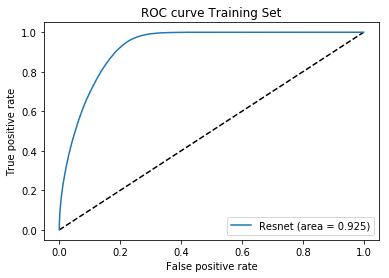

In [57]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
# Plot AUC curve
y_pred_probs = model.predict(X_train[0:200])
y_pred = np.where(y_pred_probs>0.5, 1, 0)
y_actual = Y_train[0:200]

# Training set metrics
accuracy = np.mean(y_pred==y_actual)
f1_scr = f1_score(y_actual.flatten(), y_pred.flatten())
print("Accuracy:", accuracy)
print("F1 Score:", f1_scr)

fpr_valid, tpr_valid, thresholds_test = roc_curve(y_actual.flatten(), y_pred_probs.flatten())
auc_valid = auc(fpr_valid, tpr_valid)

# Plot ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_valid, tpr_valid, label='Resnet (area = {:.3f})'.format(auc_valid))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Training Set')
plt.legend(loc='best')
plt.show()

In [ ]:
# Plot AUC curve
y_pred_probs = model.predict(X_valid)
y_pred = np.where(y_pred_probs>0.5, 1, 0)
y_actual = Y_valid

# Validation set metrics
accuracy = np.mean(y_pred==y_actual)
prec_recall = precision_recall_fscore_support(y_actual.flatten(), y_pred.flatten())
print(prec_recall)

print("Accuracy:", accuracy)
print("F1 Score:", prec_recall[2][1])

fpr_valid, tpr_valid, thresholds_test = roc_curve(y_actual.flatten(), y_pred_probs.flatten())
auc_valid = auc(fpr_valid, tpr_valid)

# Plot ROC curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_valid, tpr_valid, label='Resnet (area = {:.3f})'.format(auc_valid))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Validation Set')
plt.legend(loc='best')
plt.show()

Image:


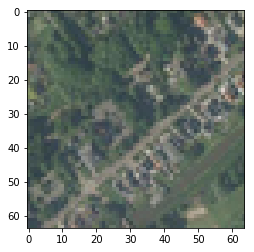

Ground truth labels:


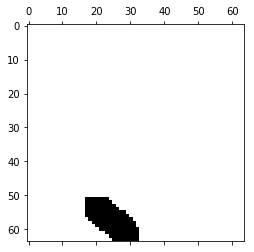

Predicted labels:
17.844282


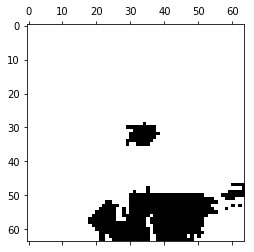

Image:


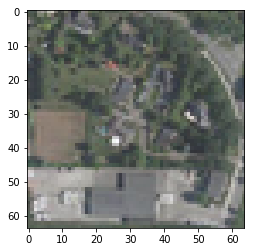

Ground truth labels:


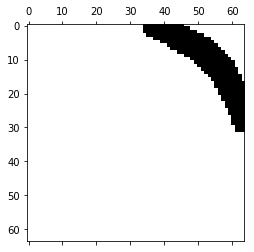

Predicted labels:
12.929296


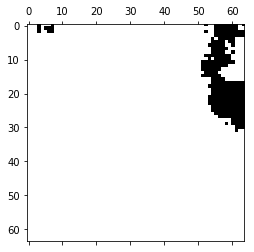

Image:


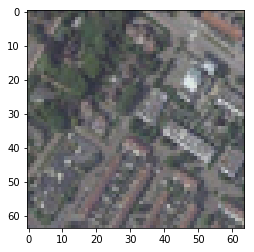

Ground truth labels:


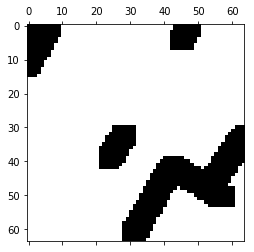

Predicted labels:
25.729807


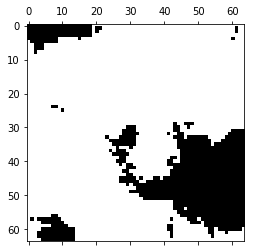

Image:


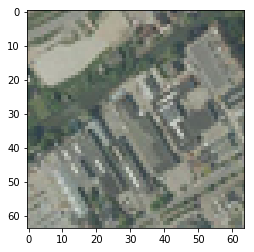

Ground truth labels:


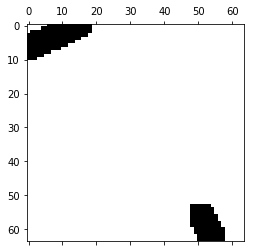

Predicted labels:
16.013084


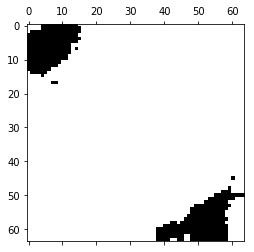

Image:


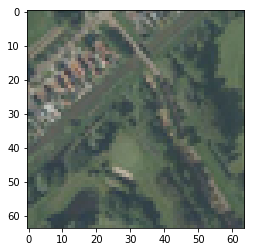

Ground truth labels:


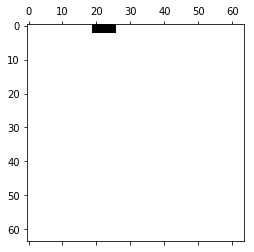

Predicted labels:
7.3692455


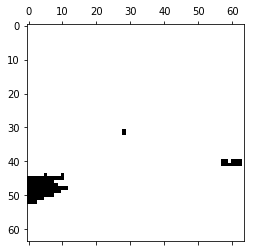

Image:


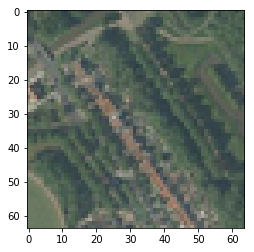

Ground truth labels:


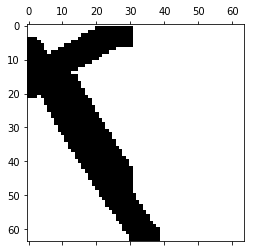

Predicted labels:
31.155436


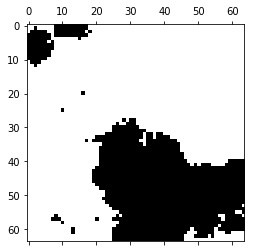

Image:


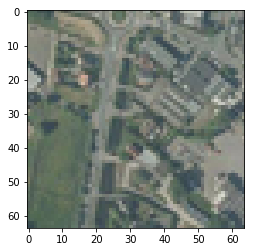

Ground truth labels:


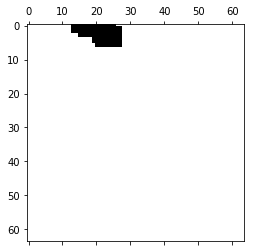

Predicted labels:
4.6158047


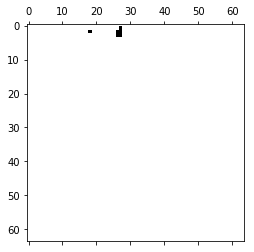

Image:


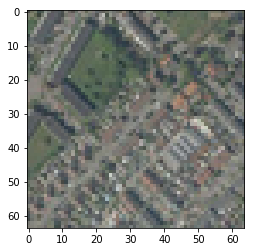

Ground truth labels:


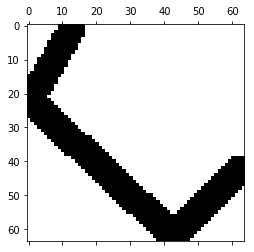

Predicted labels:
31.726568


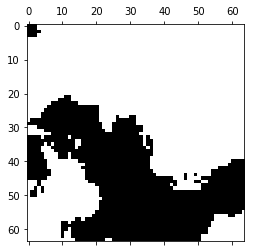

Image:


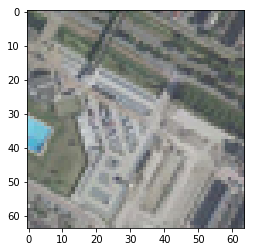

Ground truth labels:


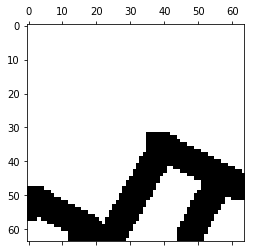

Predicted labels:
18.534868


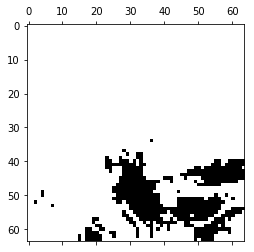

Image:


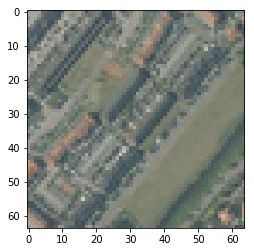

Ground truth labels:


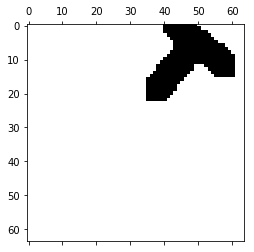

Predicted labels:
7.2728186


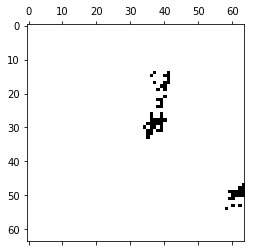

Image:


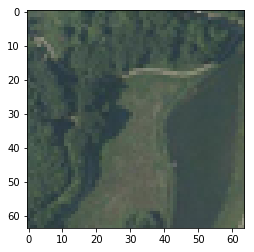

Ground truth labels:


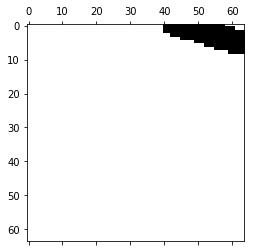

Predicted labels:
26.869835


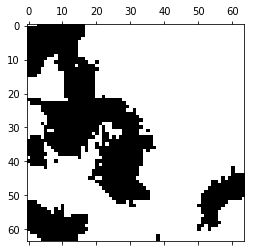

Image:


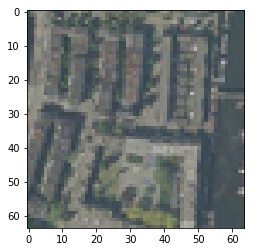

Ground truth labels:


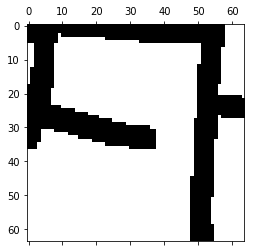

Predicted labels:
25.35348


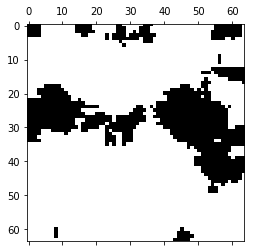

Image:


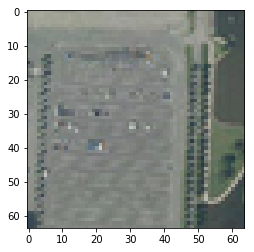

Ground truth labels:


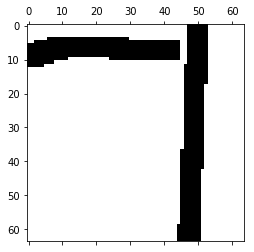

Predicted labels:
20.800512


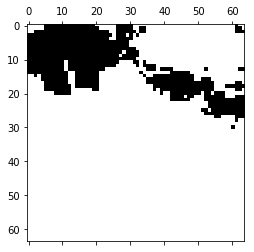

Image:


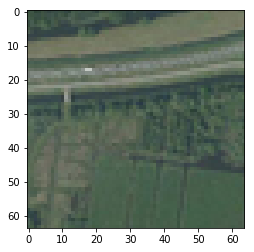

Ground truth labels:


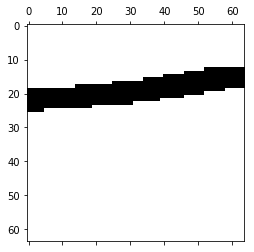

Predicted labels:
14.93954


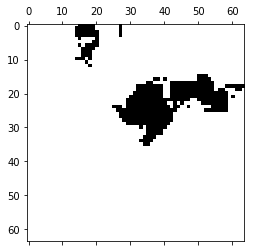

Image:


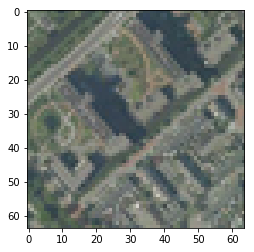

Ground truth labels:


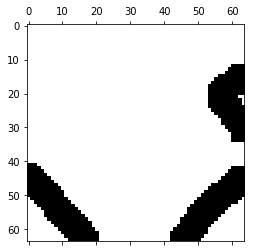

Predicted labels:
20.924274


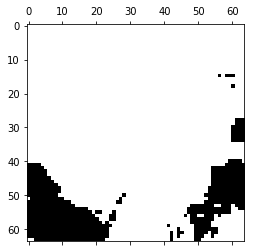

Image:


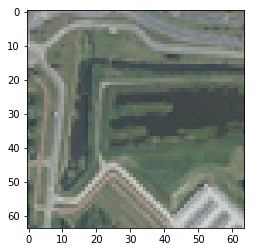

Ground truth labels:


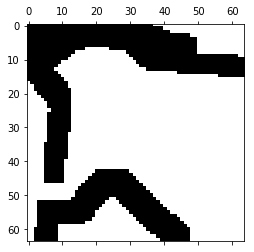

Predicted labels:
39.81065


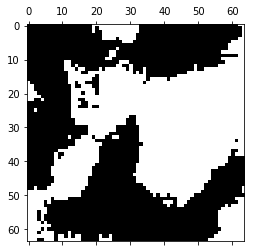

Image:


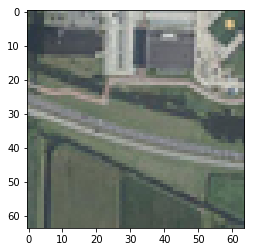

Ground truth labels:


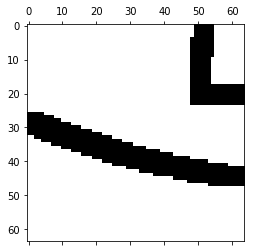

Predicted labels:
28.530592


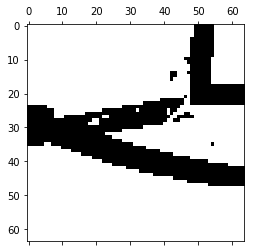

Image:


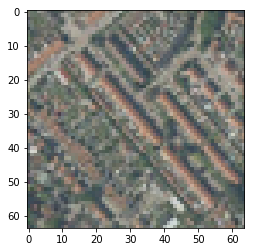

Ground truth labels:


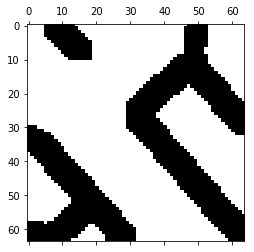

Predicted labels:
19.355942


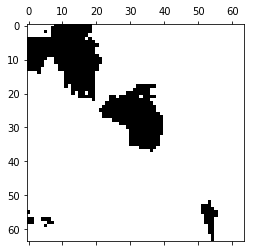

Image:


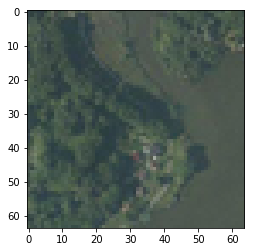

Ground truth labels:


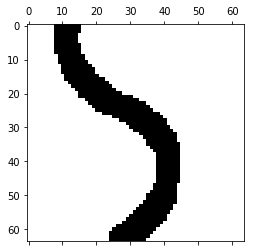

Predicted labels:
8.891826


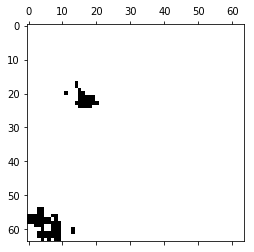

Image:


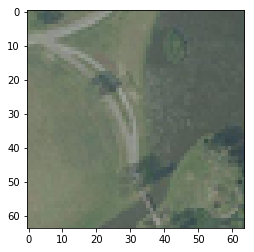

Ground truth labels:


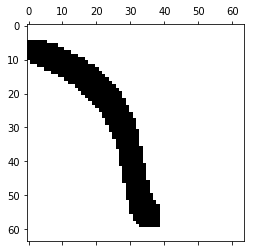

Predicted labels:
22.871891


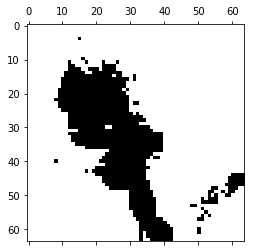

In [26]:
# Plot training examples and predictions
for i in range(20):
    image = X_train_r[i,:]
    image_std = X_train[i,:]
    labels = Y_train[i,:]

    print("Image:")
    plt.imshow(image)
    plt.show()

    print("Ground truth labels:")
    plt.spy(labels.reshape(64,64))
    plt.show()

    print("Predicted labels:")
    img_for_pred = np.ndarray(shape=(1,64,64,3))
    img_for_pred[0,:,:,:] = image
    pred_probs = model.predict(img_for_pred).reshape(64,64)
    print(np.linalg.norm(pred_probs))
    preds = np.where(pred_probs>0.5,1,0)
    plt.spy(preds)
    plt.show()

Image:


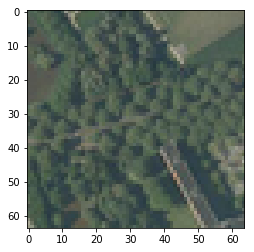

Ground truth labels:


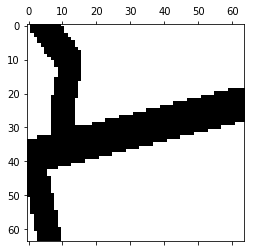

Predicted labels:
22.50693


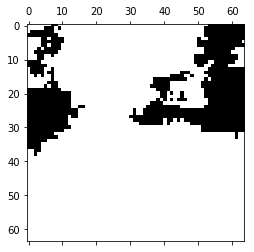

Image:


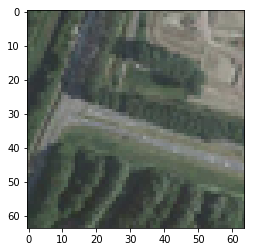

Ground truth labels:


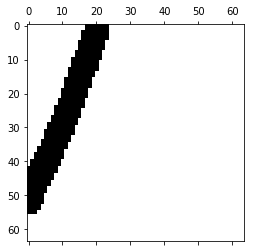

Predicted labels:
25.3019


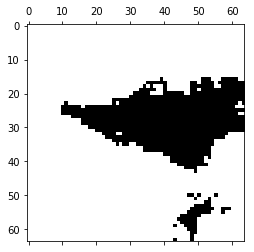

Image:


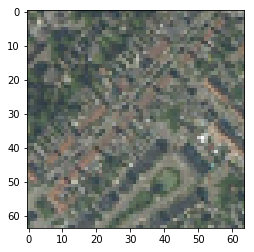

Ground truth labels:


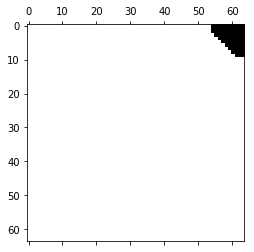

Predicted labels:
17.574482


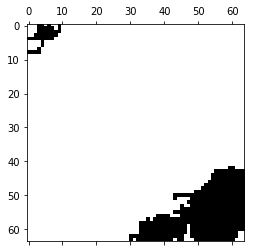

Image:


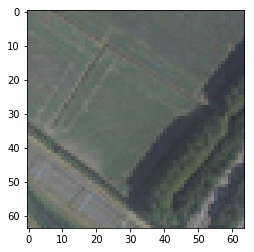

Ground truth labels:


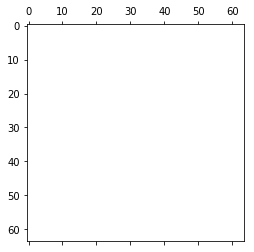

Predicted labels:
15.232512


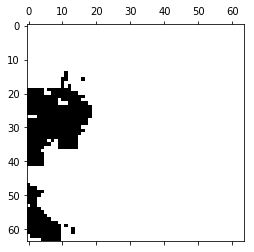

Image:


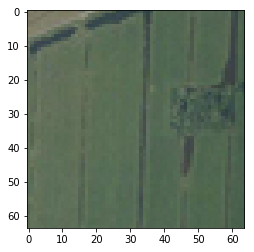

Ground truth labels:


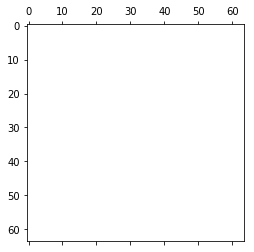

Predicted labels:
10.467749


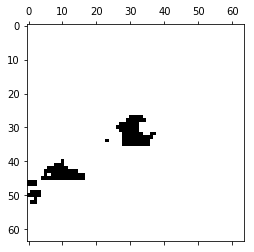

Image:


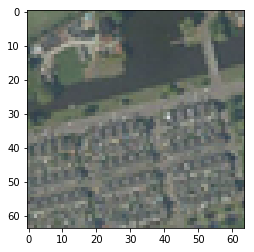

Ground truth labels:


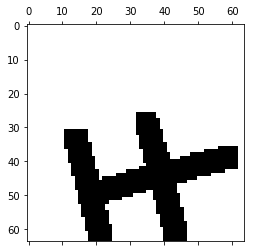

Predicted labels:
17.991817


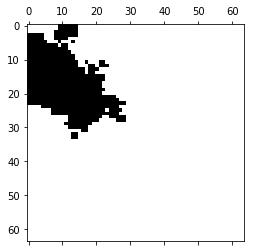

Image:


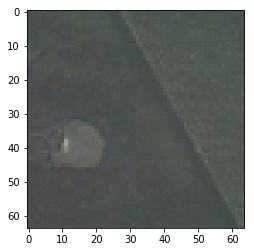

Ground truth labels:


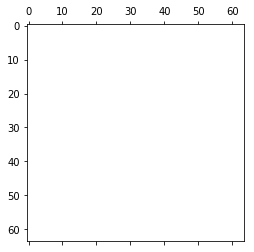

Predicted labels:
11.025795


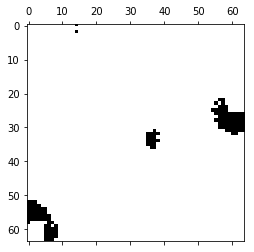

Image:


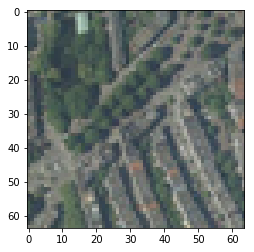

Ground truth labels:


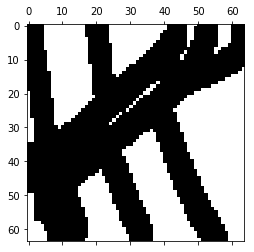

Predicted labels:
25.347914


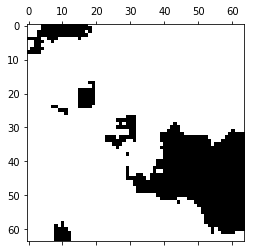

Image:


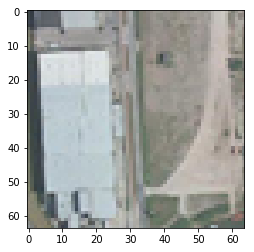

Ground truth labels:


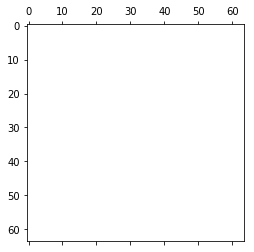

Predicted labels:
12.096668


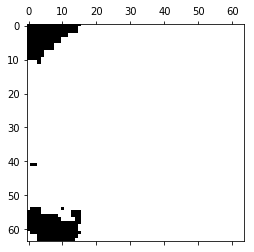

Image:


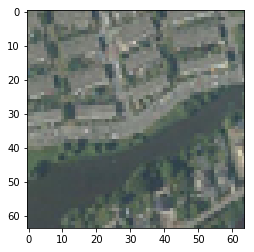

Ground truth labels:


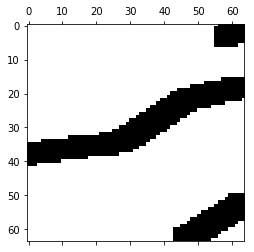

Predicted labels:
33.25124


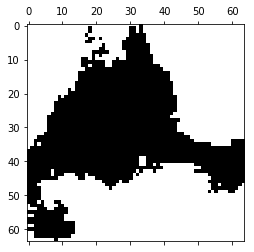

Image:


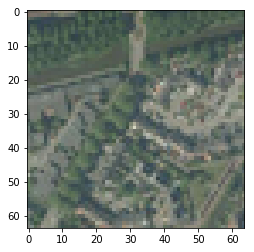

Ground truth labels:


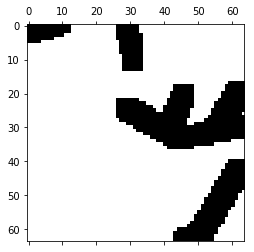

Predicted labels:
25.333069


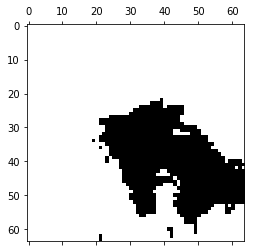

Image:


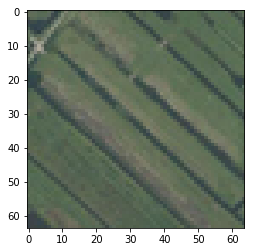

Ground truth labels:


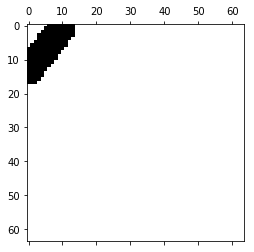

Predicted labels:
15.156619


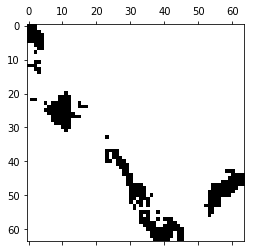

Image:


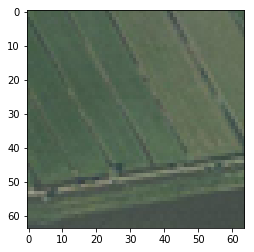

Ground truth labels:


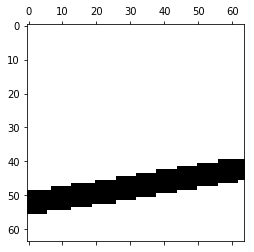

Predicted labels:
18.799488


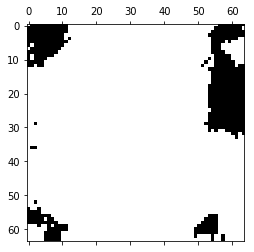

Image:


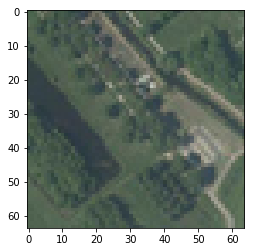

Ground truth labels:


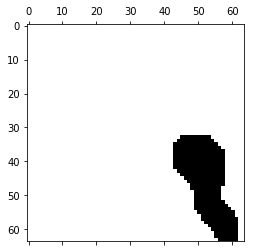

Predicted labels:
16.198757


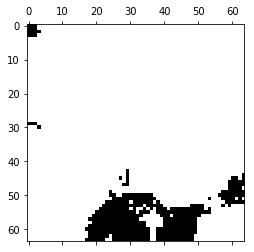

In [ ]:
# Plot validation examples and predictions
for i in range(50):
    image = X_valid_r[i,:]
    image_std = X_valid[i,:]
    labels = Y_valid[i,:]

    print("Image:")
    plt.imshow(image)
    plt.show()

    print("Ground truth labels:")
    plt.spy(labels.reshape(64,64))
    plt.show()

    print("Predicted labels:")
    img_for_pred = np.ndarray(shape=(1,64,64,3))
    img_for_pred[0,:,:,:] = image
    pred_probs = model.predict(img_for_pred).reshape(64,64)
    print(np.linalg.norm(pred_probs))
    preds = np.where(pred_probs>0.5,1,0)
    plt.spy(preds)
    plt.show()